<a href="https://colab.research.google.com/github/radifanfqrr/Quality-Air-Prediction-Jakarta/blob/main/Data_Science_Random_Forest_Prediksi_Udara_Jakarta.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Persiapan Lingkungan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving ispu_dki_all.csv to ispu_dki_all.csv


In [ ]:
data = pd.read_csv('ispu_dki_all.csv')

data.head()

,tanggal,stasiun,pm25,pm10,so2,co,o3,no2,max,critical,categori
0,2010-01-01,DKI1 (Bunderan HI),NaN,60.0,4.0,73.0,27.0,14.0,73.0,CO,SEDANG
1,2010-01-02,DKI1 (Bunderan HI),NaN,32.0,2.0,16.0,33.0,9.0,33.0,O3,BAIK
2,2010-01-03,DKI1 (Bunderan HI),NaN,27.0,2.0,19.0,20.0,9.0,27.0,PM10,BAIK
3,2010-01-04,DKI1 (Bunderan HI),NaN,22.0,2.0,16.0,15.0,6.0,22.0,PM10,BAIK
4,2010-01-05,DKI1 (Bunderan HI),NaN,25.0,2.0,17.0,15.0,8.0,25.0,PM10,BAIK


#Eksplorasi Data Awal (Initial Data Exploration)

In [ ]:
# Menampilkan informasi umum tentang dataset
data_info = data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5538 entries, 0 to 5537
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tanggal   5538 non-null   object 
 1   stasiun   5537 non-null   object 
 2   pm25      1516 non-null   float64
 3   pm10      5223 non-null   float64
 4   so2       5408 non-null   float64
 5   co        5450 non-null   float64
 6   o3        5434 non-null   float64
 7   no2       5432 non-null   float64
 8   max       5537 non-null   float64
 9   critical  5534 non-null   object 
 10  categori  5538 non-null   object 
dtypes: float64(7), object(4)
memory usage: 476.1+ KB


In [ ]:
# Menampilkan statistik deskriptif untuk setiap kolom numerik
data_description = data.describe()

In [ ]:
# Menampilkan missing values dalam dataset
missing_values = data.isnull().sum()

In [ ]:
# Menampilkan beberapa nilai unik dalam kolom 'categori' untuk memeriksa kategori kualitas udara
unique_categories = data['categori'].unique()

In [ ]:
# Hasil eksplorasi awal
data_info, data_description, missing_values, unique_categories

(None,
               pm25         pm10          so2           co           o3  \
 count  1516.000000  5223.000000  5408.000000  5450.000000  5434.000000   
 mean     89.742084    56.407046    22.436206    20.422752    77.465771   
 std      26.615960    20.010963    15.450584    11.966246    51.798101   
 min      10.000000     2.000000     0.000000     0.000000     4.000000   
 25%      71.000000    45.000000    10.000000    12.000000    36.000000   
 50%      90.000000    57.000000    18.000000    18.000000    69.000000   
 75%     107.000000    67.000000    32.000000    26.000000   103.000000   
 max     287.000000   187.000000   112.000000   119.000000   314.000000   
 
                no2          max  
 count  5432.000000  5537.000000  
 mean     14.349227    97.625790  
 std      10.051099    40.955382  
 min       1.000000     0.000000  
 25%       8.000000    70.000000  
 50%      12.000000    90.000000  
 75%      18.000000   114.000000  
 max     202.000000   314.000000  ,


#Cleaning Data

In [ ]:
missing_values

,0
tanggal,0
stasiun,1
pm25,4022
pm10,315
so2,130
co,88
o3,104
no2,106
max,1
critical,4


In [ ]:
# Hapus kolom 'pm25'
data_cleaned = data.drop(columns=['pm25'])

# Isi missing values dengan nilai rata-rata untuk kolom lainnya
# Hitung rata-rata hanya untuk kolom numerik
numeric_cols_mean = data_cleaned.select_dtypes(include=np.number).mean()
data_cleaned.fillna(numeric_cols_mean, inplace=True)

# Hapus kolom 'critical' dan 'stasiun' yang memiliki nilai missing
data_cleaned = data_cleaned.drop(columns=['critical', 'stasiun'])

In [ ]:
# Menampilkan hasil pembersihan
missing_values_after_cleaning = data_cleaned.isnull().sum()

# Hasil pembersihan dan pengecekan missing values
missing_values_after_cleaning

,0
tanggal,0
pm10,0
so2,0
co,0
o3,0
no2,0
max,0
categori,0


#Feature Engineering (Feature Creation)

In [ ]:
# Ekstraksi fitur dari kolom 'tanggal' (tahun, bulan, hari)
data_cleaned['tanggal'] = pd.to_datetime(data_cleaned['tanggal'])

data_cleaned['tahun'] = data_cleaned['tanggal'].dt.year
data_cleaned['bulan'] = data_cleaned['tanggal'].dt.month
data_cleaned['hari'] = data_cleaned['tanggal'].dt.day

In [ ]:
category_mapping = {
    'SEDANG': 0,
    'BAIK': 1,
    'TIDAK SEHAT': -1,
    'SANGAT TIDAK SEHAT': -2,
    'BERBAHAYA': -3
}

# Mengganti kategori 'categori' dengan angka yang sesuai
data_cleaned['categori'] = data_cleaned['categori'].map(category_mapping)

In [ ]:
# Menghapus baris yang memiliki kategori 'TIDAK ADA DATA' (NaN atau tidak ada data)
data_cleaned = data_cleaned.dropna(subset=['categori'])

In [ ]:
# Menampilkan beberapa baris pertama setelah encoding
data_cleaned[['tanggal', 'categori']].head()

,tanggal,categori
0,2010-01-01,0.0
1,2010-01-02,1.0
2,2010-01-03,1.0
3,2010-01-04,1.0
4,2010-01-05,1.0


In [ ]:
# Normalisasi kolom numerik (misalnya: 'pm10', 'so2', 'co', 'o3', 'no2', 'max')
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# Kolom yang akan dinormalisasi
features_to_normalize = ['pm10', 'so2', 'co', 'o3', 'no2', 'max']

In [ ]:
# Membuat objek scaler
scaler = MinMaxScaler()

In [ ]:
# Menormalisasi data
data_cleaned[features_to_normalize] = scaler.fit_transform(data_cleaned[features_to_normalize])

In [ ]:
# Menampilkan data setelah feature engineering
data_cleaned.head()

,tanggal,pm10,so2,co,o3,no2,max,categori,tahun,bulan,hari
0,2010-01-01,0.313514,0.035714,0.613445,0.074194,0.064677,0.174658,0.0,2010,1,1
1,2010-01-02,0.162162,0.017857,0.134454,0.093548,0.039801,0.037671,1.0,2010,1,2
2,2010-01-03,0.135135,0.017857,0.159664,0.051613,0.039801,0.017123,1.0,2010,1,3
3,2010-01-04,0.108108,0.017857,0.134454,0.035484,0.024876,0.000000,1.0,2010,1,4
4,2010-01-05,0.124324,0.017857,0.142857,0.035484,0.034826,0.010274,1.0,2010,1,5


# Visualisasi Data

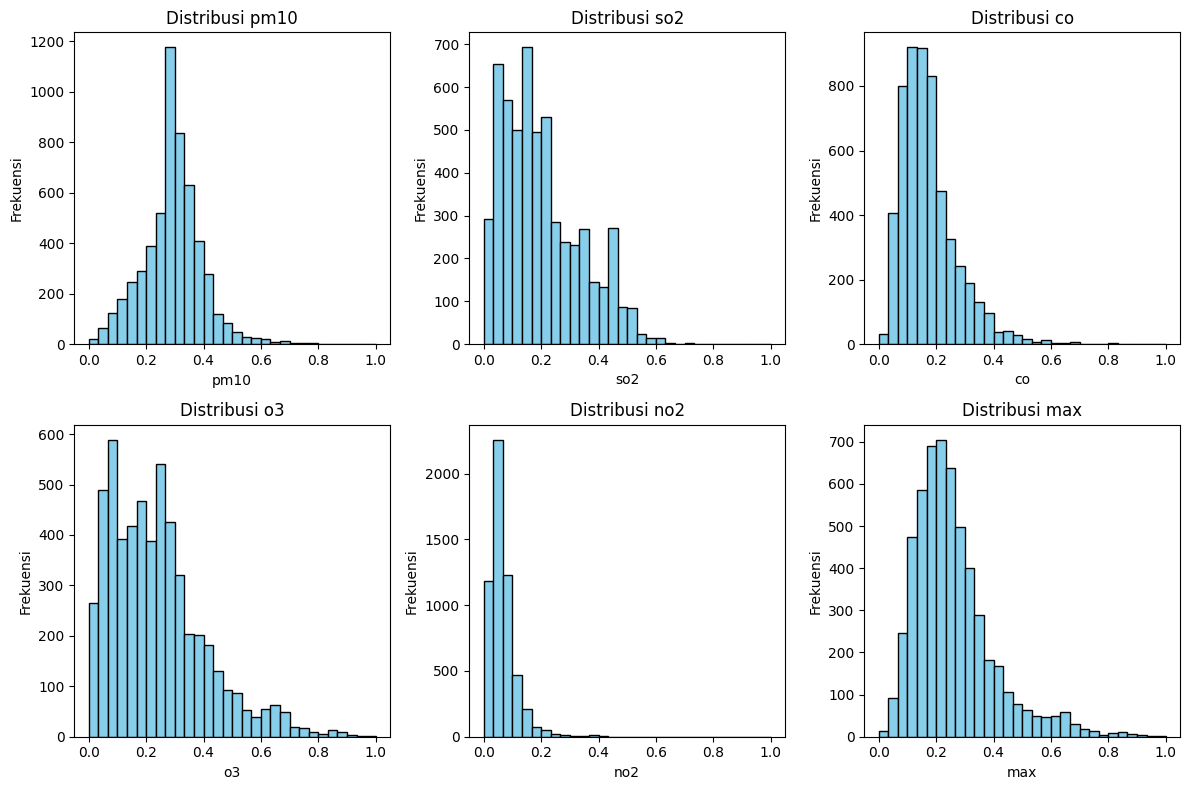

In [ ]:
# Distribusi Kolom Numerik (Histogram dan Boxplot)

# Plot histogram untuk setiap polutan
plt.figure(figsize=(12, 8))
for i, col in enumerate(['pm10', 'so2', 'co', 'o3', 'no2', 'max'], 1):
    plt.subplot(2, 3, i)
    plt.hist(data_cleaned[col], bins=30, color='skyblue', edgecolor='black')
    plt.title(f'Distribusi {col}')
    plt.xlabel(col)
    plt.ylabel('Frekuensi')
plt.tight_layout()
plt.show()

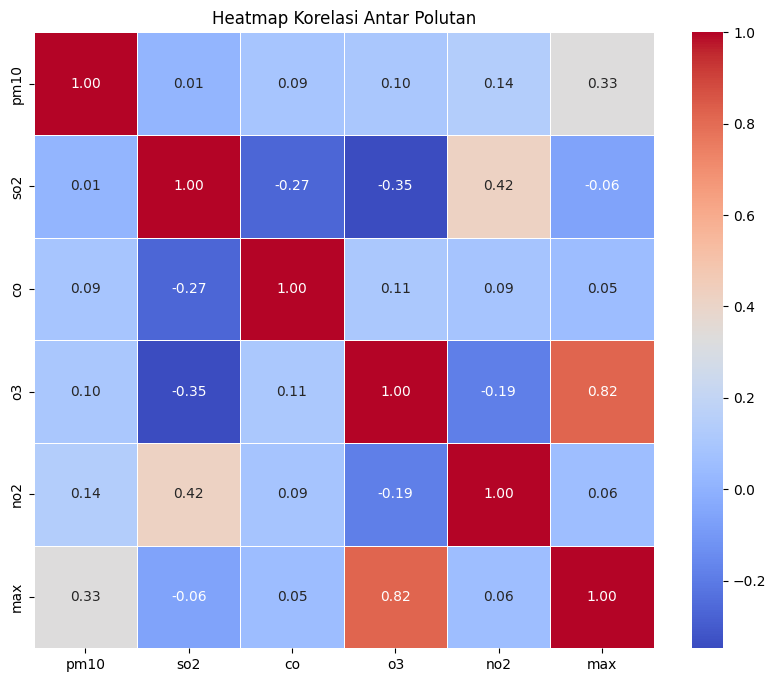

In [ ]:
# Korelasi Antar Fitur (Heatmap)
plt.figure(figsize=(10, 8))
correlation_matrix = data_cleaned[['pm10', 'so2', 'co', 'o3', 'no2', 'max']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Heatmap Korelasi Antar Polutan')
plt.show()

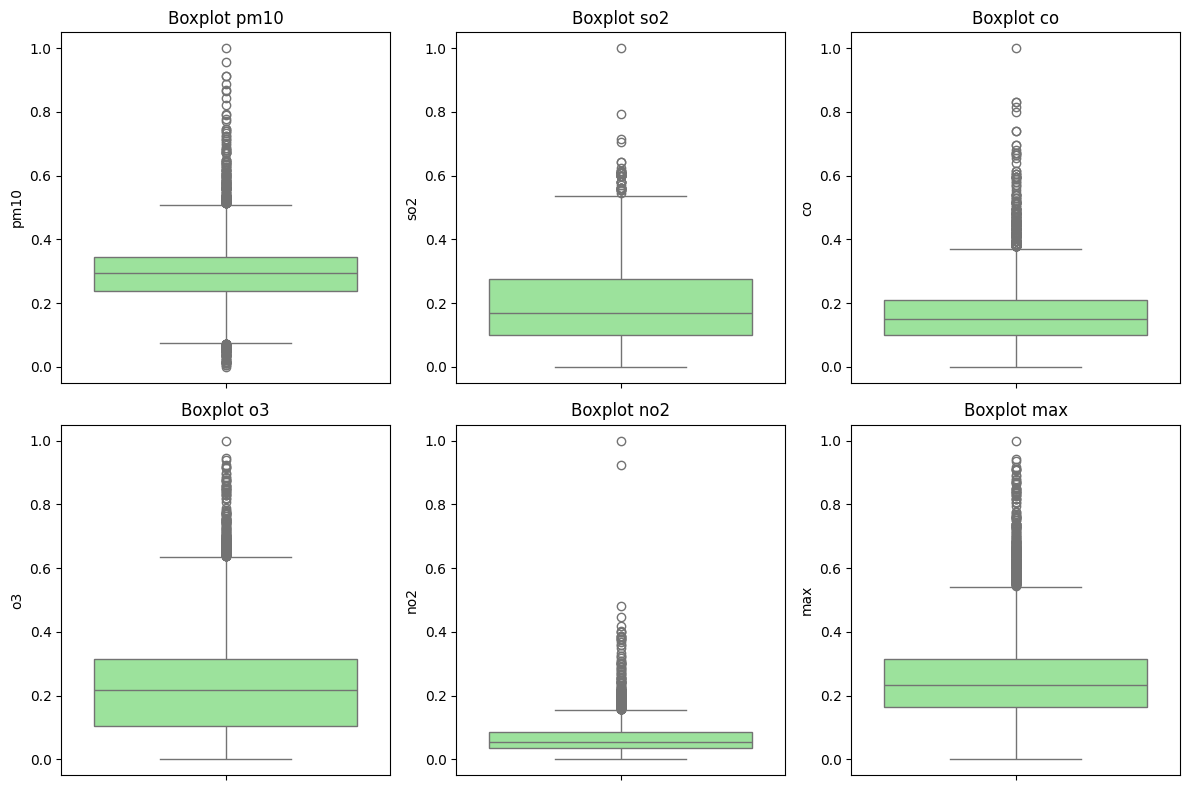

In [ ]:
# Boxplot untuk Outlier
plt.figure(figsize=(12, 8))
for i, col in enumerate(features_to_normalize, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(y=data_cleaned[col], color='lightgreen')
    plt.title(f'Boxplot {col}')
plt.tight_layout()
plt.show()

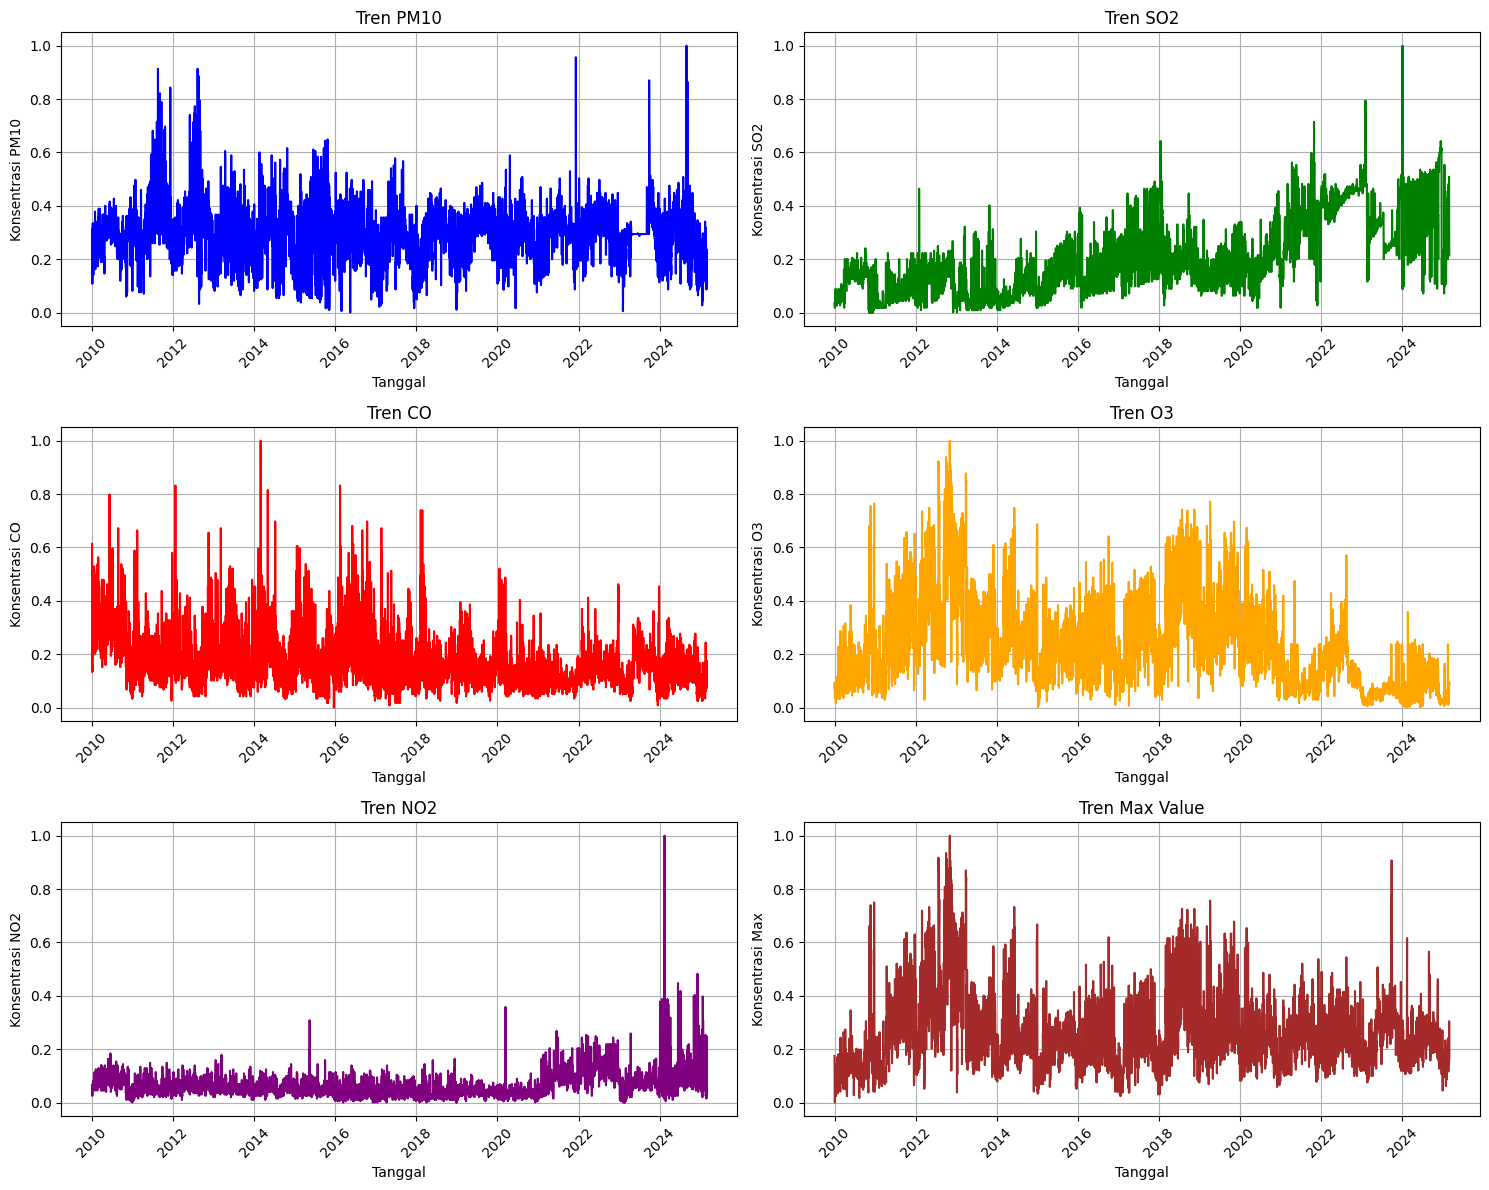

In [ ]:
# Visualisasi Tren Polutan yang lebih jelas
# Memisahkan tiap polutan dalam subplots terpisah untuk memperjelas tren

fig, axes = plt.subplots(3, 2, figsize=(15, 12))
fig.tight_layout(pad=5.0)

# Plot setiap polutan secara terpisah
axes[0, 0].plot(data_cleaned['tanggal'], data_cleaned['pm10'], label='PM10', color='blue')
axes[0, 0].set_title('Tren PM10')
axes[0, 0].set_xlabel('Tanggal')
axes[0, 0].set_ylabel('Konsentrasi PM10')
axes[0, 0].grid(True)
axes[0, 0].tick_params(axis='x', rotation=45)

axes[0, 1].plot(data_cleaned['tanggal'], data_cleaned['so2'], label='SO2', color='green')
axes[0, 1].set_title('Tren SO2')
axes[0, 1].set_xlabel('Tanggal')
axes[0, 1].set_ylabel('Konsentrasi SO2')
axes[0, 1].grid(True)
axes[0, 1].tick_params(axis='x', rotation=45)

axes[1, 0].plot(data_cleaned['tanggal'], data_cleaned['co'], label='CO', color='red')
axes[1, 0].set_title('Tren CO')
axes[1, 0].set_xlabel('Tanggal')
axes[1, 0].set_ylabel('Konsentrasi CO')
axes[1, 0].grid(True)
axes[1, 0].tick_params(axis='x', rotation=45)

axes[1, 1].plot(data_cleaned['tanggal'], data_cleaned['o3'], label='O3', color='orange')
axes[1, 1].set_title('Tren O3')
axes[1, 1].set_xlabel('Tanggal')
axes[1, 1].set_ylabel('Konsentrasi O3')
axes[1, 1].grid(True)
axes[1, 1].tick_params(axis='x', rotation=45)

axes[2, 0].plot(data_cleaned['tanggal'], data_cleaned['no2'], label='NO2', color='purple')
axes[2, 0].set_title('Tren NO2')
axes[2, 0].set_xlabel('Tanggal')
axes[2, 0].set_ylabel('Konsentrasi NO2')
axes[2, 0].grid(True)
axes[2, 0].tick_params(axis='x', rotation=45)

axes[2, 1].plot(data_cleaned['tanggal'], data_cleaned['max'], label='Max Value', color='brown')
axes[2, 1].set_title('Tren Max Value')
axes[2, 1].set_xlabel('Tanggal')
axes[2, 1].set_ylabel('Konsentrasi Max')
axes[2, 1].grid(True)
axes[2, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

<ipython-input-57-2068741801>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=avg_by_station, x='stasiun', y=col, palette='viridis')
<ipython-input-57-2068741801>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=avg_by_station, x='stasiun', y=col, palette='viridis')
<ipython-input-57-2068741801>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=avg_by_station, x='stasiun', y=col, palette='viridis')
<ipython-input-57-2068741801>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed 

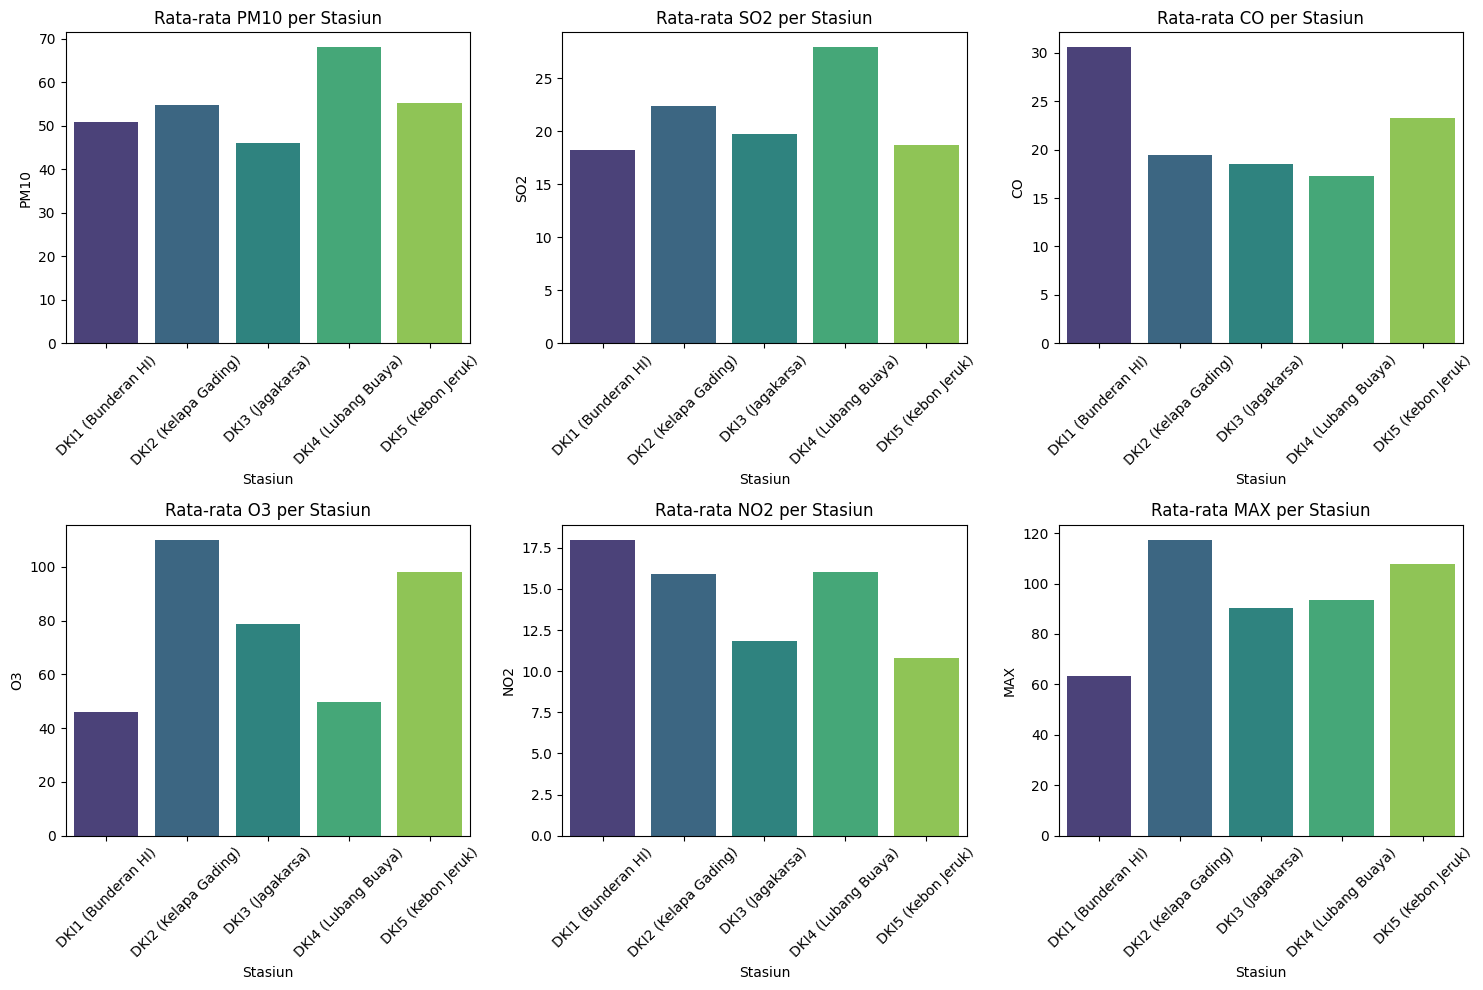

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Pastikan kolom 'stasiun' tersedia
if 'stasiun' in data.columns:
    # Bersihkan nilai missing dan ubah jadi string
    data_cleaned['stasiun'] = data['stasiun'].astype(str)
    data_filtered = data.dropna(subset=['stasiun'])

    # Pilih kolom polutan
    polutan_cols = ['pm10', 'so2', 'co', 'o3', 'no2', 'max']

    # Hitung rata-rata per stasiun
    avg_by_station = data_filtered.groupby('stasiun')[polutan_cols].mean().reset_index()

    # Visualisasi dengan barplot untuk setiap polutan
    plt.figure(figsize=(15, 10))
    for i, col in enumerate(polutan_cols, 1):
        plt.subplot(2, 3, i)
        sns.barplot(data=avg_by_station, x='stasiun', y=col, palette='viridis')
        plt.title(f'Rata-rata {col.upper()} per Stasiun')
        plt.xlabel('Stasiun')
        plt.ylabel(f'{col.upper()}')
        plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Random Forest Classification

In [ ]:
# Persiapan Data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [ ]:
# Memisahkan fitur (X) dan target (y)
X = data_cleaned.drop(columns=['tanggal', 'categori'])  # Menghapus kolom 'tanggal' dan 'categori' dari fitur
y = data_cleaned['categori']  # Misalnya kita memilih kategori 'BAIK' sebagai target, Anda bisa menyesuaikan

In [ ]:
# Pembagian data menjadi training dan testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Menampilkan dimensi data untuk memastikan pembagian
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4427, 9), (1107, 9), (4427,), (1107,))

##Model Training

In [ ]:
# Membangun dan melatih model Random Forest
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# Membangun model Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

In [ ]:
# Melatih model
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
# Memprediksi hasil pada data testing
y_pred = rf_model.predict(X_test)

## Evaluasi Model (Model Evaluation)

In [ ]:
# Evaluasi model
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [ ]:
# Menghitung akurasi
accuracy = accuracy_score(y_test, y_pred)

In [ ]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

In [ ]:
# Classification Report
class_report = classification_report(y_test, y_pred)

In [ ]:
# Menampilkan Precision, Recall, dan F1-Score

# Define the category mapping again to get the original labels in the correct order
category_mapping = {
    'BERBAHAYA': -3,         # Make sure the order matches the numerical representation
    'SANGAT TIDAK SEHAT': -2,
    'TIDAK SEHAT': -1,
    'SEDANG': 0,
    'BAIK': 1
}

# Get the list of original category names in the correct order based on the numerical values
# present in y_test and y_pred
unique_numerical_labels = sorted(list(set(y_test.unique()).union(set(y_pred))))
target_names_list = [list(category_mapping.keys())[list(category_mapping.values()).index(label)] for label in unique_numerical_labels]


report = classification_report(y_test, y_pred, target_names=target_names_list, output_dict=False)
print(report)

                    precision    recall  f1-score   support

SANGAT TIDAK SEHAT       1.00      1.00      1.00        38
       TIDAK SEHAT       1.00      1.00      1.00       368
            SEDANG       1.00      1.00      1.00       624
              BAIK       1.00      0.97      0.99        77

          accuracy                           1.00      1107
         macro avg       1.00      0.99      1.00      1107
      weighted avg       1.00      1.00      1.00      1107



In [ ]:
# Menghitung Precision, Recall, dan F1-Score

# Define the category mapping again to get the original labels in the correct order
category_mapping = {
    'BERBAHAYA': -3,         # Make sure the order matches the numerical representation
    'SANGAT TIDAK SEHAT': -2,
    'TIDAK SEHAT': -1,
    'SEDANG': 0,
    'BAIK': 1
}

# Get the list of original category names in the correct order based on the numerical values
# present in y_test and y_pred
unique_numerical_labels = sorted(list(set(y_test.unique()).union(set(y_pred))))
target_names_list = [list(category_mapping.keys())[list(category_mapping.values()).index(label)] for label in unique_numerical_labels]

# Set output_dict=True to get the report as a dictionary
report = classification_report(y_test, y_pred, target_names=target_names_list, output_dict=True)

# Menampilkan metrik evaluasi secara lebih terstruktur
for class_name, metrics in report.items():
    # Exclude the overall metrics from the individual class display
    if class_name not in ['accuracy', 'macro avg', 'weighted avg']:
        print(f"Class: {class_name}")
        print(f"  Precision: {metrics['precision']:.2f}")
        print(f"  Recall: {metrics['recall']:.2f}")
        print(f"  F1-Score: {metrics['f1-score']:.2f}")
        print('-' * 40)

# You can also display the overall metrics separately if desired
print(" ")
print("Overall Metrics:")
print(f"  Accuracy: {report['accuracy']:.2f}")
print(f"  Macro Avg Precision: {report['macro avg']['precision']:.2f}")
print(f"  Macro Avg Recall: {report['macro avg']['recall']:.2f}")
print(f"  Macro Avg F1-Score: {report['macro avg']['f1-score']:.2f}")
print(f"  Weighted Avg Precision: {report['weighted avg']['precision']:.2f}")
print(f"  Weighted Avg Recall: {report['weighted avg']['recall']:.2f}")
print(f"  Weighted Avg F1-Score: {report['weighted avg']['f1-score']:.2f}")

Class: SANGAT TIDAK SEHAT
  Precision: 1.00
  Recall: 1.00
  F1-Score: 1.00
----------------------------------------
Class: TIDAK SEHAT
  Precision: 1.00
  Recall: 1.00
  F1-Score: 1.00
----------------------------------------
Class: SEDANG
  Precision: 1.00
  Recall: 1.00
  F1-Score: 1.00
----------------------------------------
Class: BAIK
  Precision: 1.00
  Recall: 0.97
  F1-Score: 0.99
----------------------------------------
 
Overall Metrics:
  Accuracy: 1.00
  Macro Avg Precision: 1.00
  Macro Avg Recall: 0.99
  Macro Avg F1-Score: 1.00
  Weighted Avg Precision: 1.00
  Weighted Avg Recall: 1.00
  Weighted Avg F1-Score: 1.00


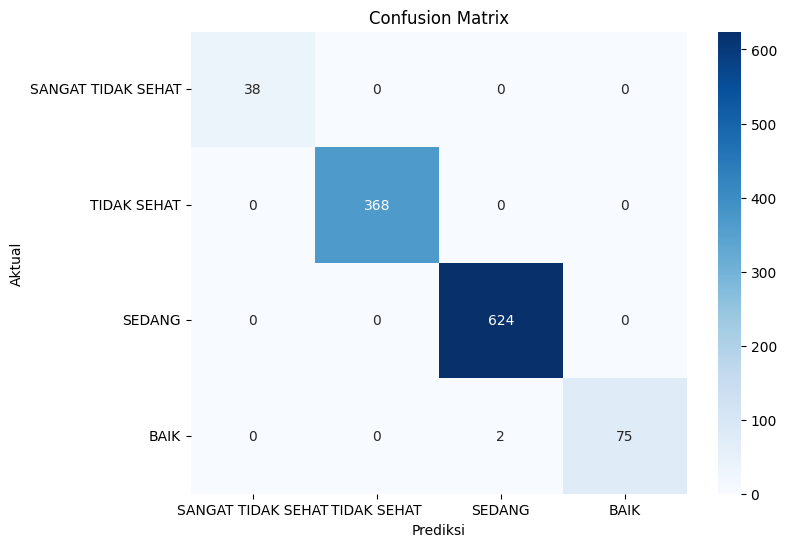

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Define the category mapping again to get the original labels
category_mapping = {
    'SEDANG': 0,
    'BAIK': 1,
    'TIDAK SEHAT': -1,
    'SANGAT TIDAK SEHAT': -2,
    'BERBAHAYA': -3
}

# Get the unique numerical labels from the actual test data
unique_labels_numeric = np.unique(y_test)

# Create a list of corresponding category names based on the unique numerical labels
# Sort the unique labels to ensure the order matches the confusion matrix
sorted_unique_labels_numeric = sorted(unique_labels_numeric)
tick_labels = [list(category_mapping.keys())[list(category_mapping.values()).index(label)] for label in sorted_unique_labels_numeric]


# Menampilkan Confusion Matrix sebagai Heatmap
plt.figure(figsize=(8, 6))
# Use the created tick_labels list for xticklabels and yticklabels
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=tick_labels, yticklabels=tick_labels)
plt.title('Confusion Matrix')
plt.xlabel('Prediksi')
plt.ylabel('Aktual')
plt.show()

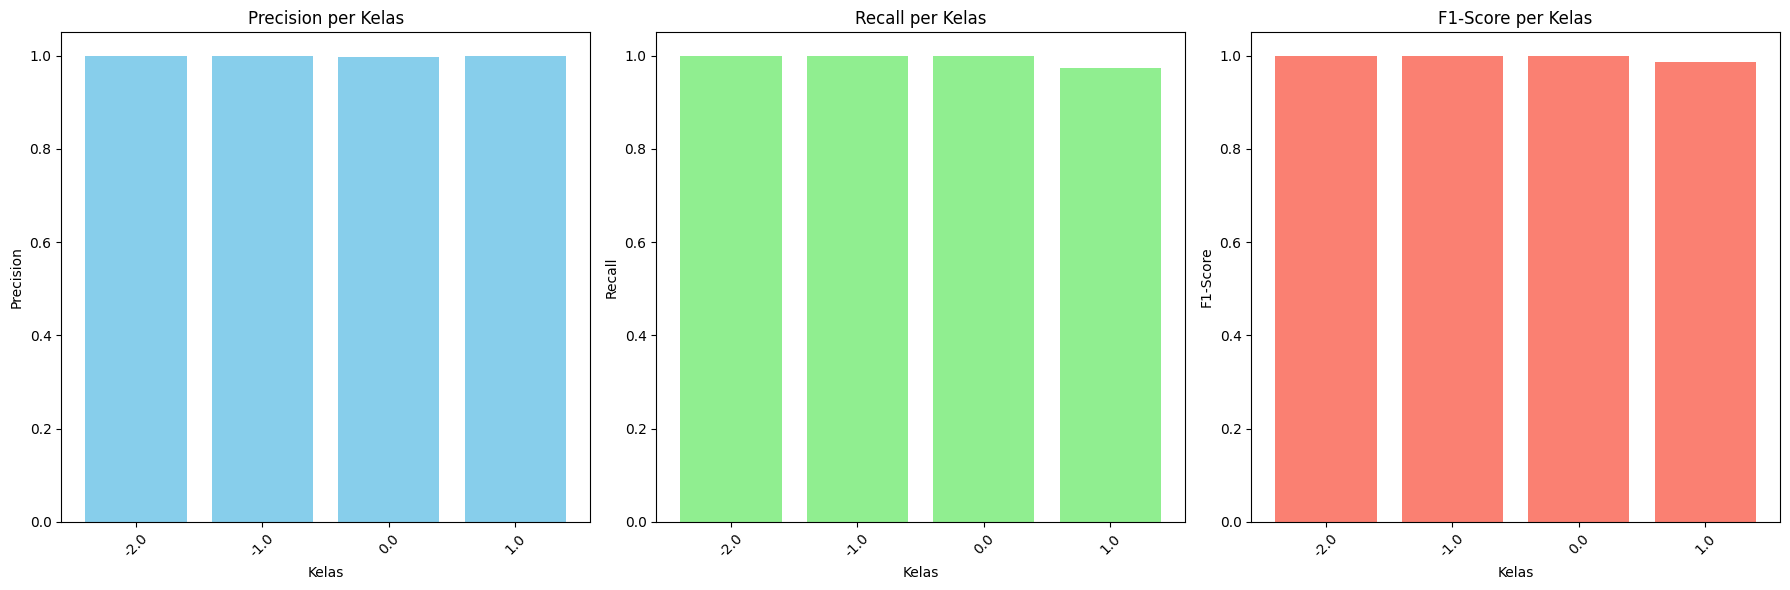

In [ ]:
from sklearn.metrics import classification_report
import pandas as pd

# Menghitung Precision, Recall, dan F1-Score
report = classification_report(y_test, y_pred, output_dict=True)

# Mengubah laporan menjadi DataFrame untuk visualisasi lebih mudah
report_df = pd.DataFrame(report).transpose()

# Menampilkan bar plot untuk Precision, Recall, dan F1-Score
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Precision plot
axes[0].bar(report_df.index[:-3], report_df['precision'][:-3], color='skyblue')
axes[0].set_title('Precision per Kelas')
axes[0].set_xlabel('Kelas')
axes[0].set_ylabel('Precision')
axes[0].tick_params(axis='x', rotation=45)

# Recall plot
axes[1].bar(report_df.index[:-3], report_df['recall'][:-3], color='lightgreen')
axes[1].set_title('Recall per Kelas')
axes[1].set_xlabel('Kelas')
axes[1].set_ylabel('Recall')
axes[1].tick_params(axis='x', rotation=45)

# F1-Score plot
axes[2].bar(report_df.index[:-3], report_df['f1-score'][:-3], color='salmon')
axes[2].set_title('F1-Score per Kelas')
axes[2].set_xlabel('Kelas')
axes[2].set_ylabel('F1-Score')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Random Forest Reggression

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving ispu_dki_all.csv to ispu_dki_all (1).csv


In [ ]:
data = pd.read_csv('ispu_dki_all.csv')

data.head()

,tanggal,stasiun,pm25,pm10,so2,co,o3,no2,max,critical,categori
0,2010-01-01,DKI1 (Bunderan HI),NaN,60.0,4.0,73.0,27.0,14.0,73.0,CO,SEDANG
1,2010-01-02,DKI1 (Bunderan HI),NaN,32.0,2.0,16.0,33.0,9.0,33.0,O3,BAIK
2,2010-01-03,DKI1 (Bunderan HI),NaN,27.0,2.0,19.0,20.0,9.0,27.0,PM10,BAIK
3,2010-01-04,DKI1 (Bunderan HI),NaN,22.0,2.0,16.0,15.0,6.0,22.0,PM10,BAIK
4,2010-01-05,DKI1 (Bunderan HI),NaN,25.0,2.0,17.0,15.0,8.0,25.0,PM10,BAIK


In [ ]:
# Menampilkan missing values dalam dataset
missing_values = data.isnull().sum()

In [ ]:
missing_values

,0
tanggal,0
stasiun,1
pm25,4022
pm10,315
so2,130
co,88
o3,104
no2,106
max,1
critical,4


In [ ]:
# Hapus kolom 'pm25' karena memiliki terlalu banyak missing values
data_cleaned = data.drop(columns=['pm25'], errors='ignore')

In [ ]:
# Ganti missing values pada kolom numerik dengan nilai rata-rata
data_cleaned.fillna(data_cleaned.mean(numeric_only=True), inplace=True)

In [ ]:
# Hapus baris yang memiliki missing values pada kolom 'stasiun', 'max', dan 'critical'
data_cleaned = data_cleaned.dropna(subset=['stasiun', 'max', 'critical'])

In [ ]:
missing_values = data_cleaned.isnull().sum()

In [ ]:
missing_values

,0
tanggal,0
stasiun,0
pm10,0
so2,0
co,0
o3,0
no2,0
max,0
critical,0
categori,0


In [ ]:
from sklearn.model_selection import train_test_split

# Persiapan fitur dan target
X = data_cleaned[['so2', 'co', 'o3', 'no2']]  # Fitur yang digunakan
y = data_cleaned['pm10']  # Target yang ingin diprediksi (PM10)

# Memisahkan data menjadi data latih (train) dan data uji (test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Menampilkan ukuran data latih dan data uji
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4426, 4), (1107, 4), (4426,), (1107,))

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Model Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Evaluasi model Random Forest
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

# Menampilkan hasil evaluasi
print(f"  MAE: {mae_rf:.2f}")
print(f"  RMSE: {rmse_rf:.2f}")
print(f"  R2: {r2_rf:.2f}")

  MAE: 12.10
  RMSE: 16.85
  R2: 0.27


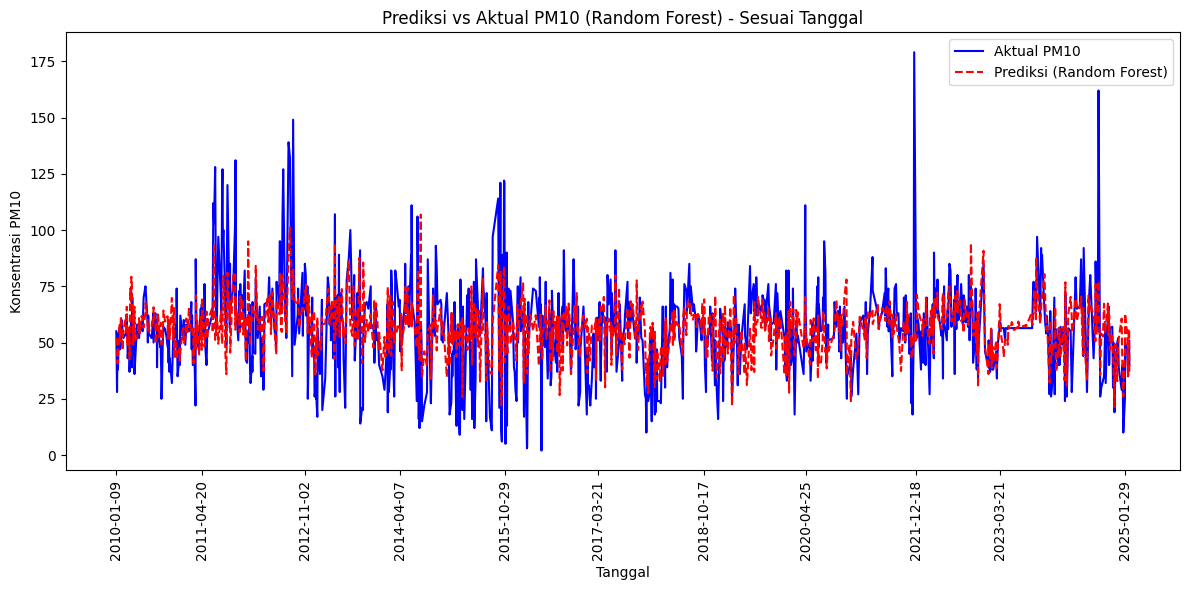

In [ ]:
# Visualisasi prediksi vs aktual dengan tanggal
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


test_indices = X_test.index

# Create a DataFrame for plotting
plot_data = pd.DataFrame({
    'tanggal': data_cleaned.loc[test_indices, 'tanggal'], # Get the original dates based on the test indices
    'Aktual PM10': y_test,
    'Prediksi PM10': y_pred_rf
})

# Ensure the 'tanggal' column is in datetime format
plot_data['tanggal'] = pd.to_datetime(plot_data['tanggal'])

# Sort the data by date for proper plotting of the time series
plot_data_sorted = plot_data.sort_values(by='tanggal').reset_index(drop=True)

# Mengatur rotasi label tanggal yang lebih besar dan memilih interval tanggal yang lebih jarang
plt.figure(figsize=(12, 6))
plt.plot(plot_data_sorted['tanggal'], plot_data_sorted['Aktual PM10'], label='Aktual PM10', color='blue')
plt.plot(plot_data_sorted['tanggal'], plot_data_sorted['Prediksi PM10'], label='Prediksi (Random Forest)', color='red', linestyle='dashed')

plt.title('Prediksi vs Aktual PM10 (Random Forest) - Sesuai Tanggal')
plt.xlabel('Tanggal')
plt.ylabel('Konsentrasi PM10')

# Memperbaiki tampilan tanggal di sumbu x
plt.xticks(rotation=90)  # Mengubah rotasi menjadi 90 derajat agar lebih terbaca

# Generate ticks and labels based on the sorted datetime objects
# This method correctly handles datetime objects for generating labels
date_ticks = plot_data_sorted['tanggal'].iloc[::max(1, int(len(plot_data_sorted['tanggal']) / 10))] # Ensure step is at least 1
plt.xticks(ticks=date_ticks, labels=date_ticks.dt.strftime('%Y-%m-%d')) # Use the datetime objects directly for ticks and labels

plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300, 500, 700],       # lebih banyak variasi jumlah pohon
    'max_depth': [5, 10, 20, 30, 50, None],         # kedalaman pohon, termasuk None (tanpa batas)
    'min_samples_split': [2, 5, 10, 20],            # minimal data split di node
    'min_samples_leaf': [1, 2, 4, 8],               # minimal data di daun
    'bootstrap': [True, False],                     # pakai bootstrapping atau tidak
    'max_features': ['auto', 'sqrt', 'log2']        # strategi jumlah fitur di setiap split
}

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

rf_model = RandomForestRegressor(random_state=42)

random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_grid,
    n_iter=60,                 # Naikkan iterasi supaya makin banyak kombinasi dicoba
    cv=5,
    n_jobs=-1,
    verbose=2,
    scoring='neg_root_mean_squared_error',
    random_state=42
)

random_search.fit(X_train, y_train)

# Model dan parameter terbaik
best_model = random_search.best_estimator_
print("Best hyperparameters:", random_search.best_params_)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
95 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
95 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/

Best hyperparameters: {'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 50, 'bootstrap': True}


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Prediksi dan evaluasi
y_pred_best = best_model.predict(X_test)
mae_best = mean_absolute_error(y_test, y_pred_best)
rmse_best = np.sqrt(mean_squared_error(y_test, y_pred_best))
r2_best = r2_score(y_test, y_pred_best)

print(f'MAE (Best Model): {mae_best:.4f}')
print(f'RMSE (Best Model): {rmse_best:.4f}')
print(f'R² (Best Model): {r2_best:.4f}')

MAE (Best Model): 11.8818
RMSE (Best Model): 16.5499
R² (Best Model): 0.2940


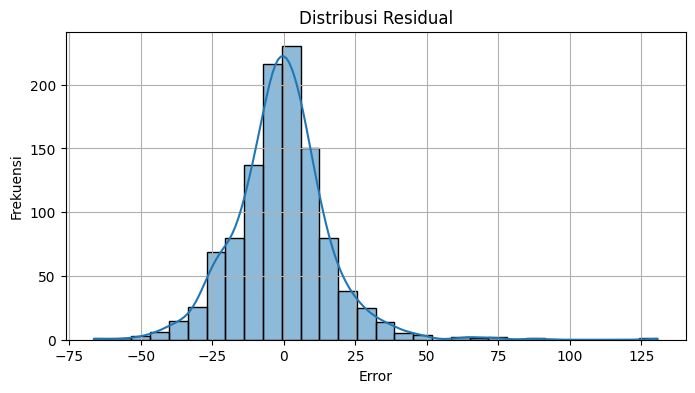

In [ ]:
# Visualisasi residual
residuals = y_test - y_pred_best
plt.figure(figsize=(8, 4))
sns.histplot(residuals, bins=30, kde=True)
plt.title("Distribusi Residual")
plt.xlabel("Error")
plt.ylabel("Frekuensi")
plt.grid(True)
plt.show()

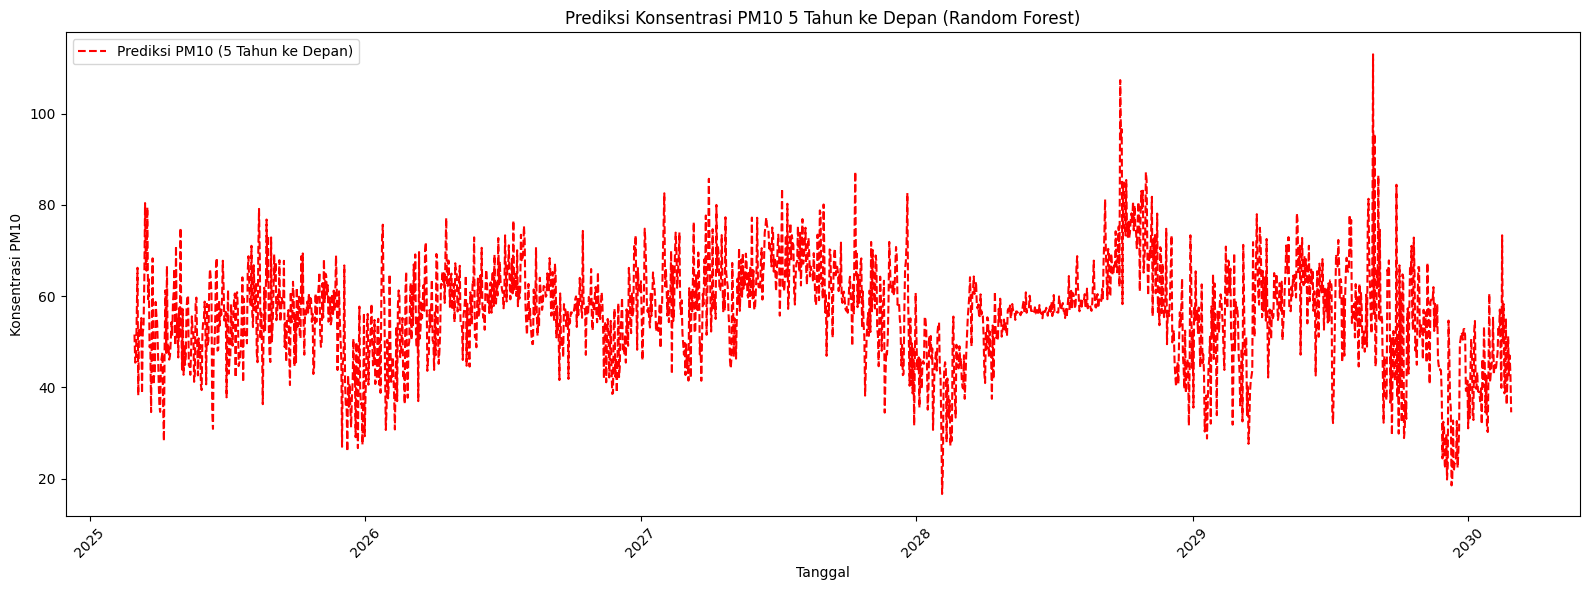

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Pastikan tanggal sudah dalam format datetime
data_cleaned['tanggal'] = pd.to_datetime(data_cleaned['tanggal'])

# Ambil 1825 hari terakhir dari data_cleaned
last_1825 = data_cleaned.sort_values(by='tanggal').tail(1825).copy()

# Siapkan fitur untuk prediksi masa depan
future_X = last_1825[['so2', 'co', 'o3', 'no2']].reset_index(drop=True)

# Buat rentang tanggal 5 tahun ke depan
last_date = data_cleaned['tanggal'].max()
future_dates_5yr = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=1825, freq='D')

# Prediksi dengan model terbaik
future_pred_pm10_5yr = best_model.predict(future_X)

# Buat DataFrame hasil prediksi
future_pred_df_5yr = pd.DataFrame({
    'tanggal': future_dates_5yr,
    'Prediksi PM10': future_pred_pm10_5yr
})

# Visualisasi hasil prediksi
plt.figure(figsize=(16, 6))
plt.plot(future_pred_df_5yr['tanggal'], future_pred_df_5yr['Prediksi PM10'],
         label='Prediksi PM10 (5 Tahun ke Depan)', color='red', linestyle='dashed')
plt.title('Prediksi Konsentrasi PM10 5 Tahun ke Depan (Random Forest)')
plt.xlabel('Tanggal')
plt.ylabel('Konsentrasi PM10')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()
